## Data analysis 

According to the problem instructions, these are the variables on the datasets: 

**train.csv & test.csv:**  

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee 20usd fee assigned to responsible judgments
    state_fee - 10usd fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations

**train.csv only:**

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant
___

In [4]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 

### **Preliminary selection of variables**: 
Based on their description, the following variables seem a reasonable starting choice of features to consider: 
- "violation_street_name",
- "ticket_issued_date",
- "hearing_date",
- "disposition",
- "fine_amount",
- "discount_amount",
- "judgment_amount", 
- "compliance" (target)

The names of agency and inspector issuing the ticket, as well as the name and mailing address of the violator, are left out for the moment. 

Let's drop missing values and check the distributions of the numerical variables:

In [2]:
df1= df[ ["violation_street_name","ticket_issued_date","hearing_date","disposition",
          "fine_amount","discount_amount",
          "judgment_amount", "compliance"]].copy()

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
print("after droping na values: {}".format(len(df1)))

df1["compliance"].astype("category",inplace=True)
df1.describe()

initial number of tickets: 250306
after droping na values: 159653


,fine_amount,discount_amount,judgment_amount,compliance
count,159653.000000,159653.000000,159653.000000,159653.000000
mean,356.836095,0.167300,420.462796,0.071599
std,675.527243,3.959425,742.445609,0.257824
min,0.000000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,250.000000,0.000000
50%,250.000000,0.000000,305.000000,0.000000
75%,250.000000,0.000000,305.000000,0.000000
max,10000.000000,350.000000,11030.000000,1.000000


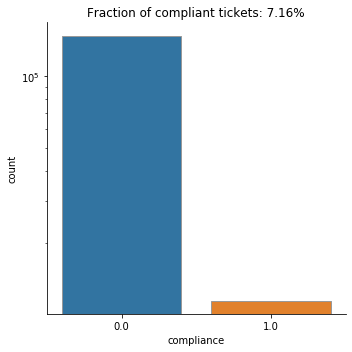

In [3]:
sns.catplot(x="compliance", kind="count", edgecolor=".6", data=df1)
plt.gca().set_title("Fraction of compliant tickets: {:0.2f}%".format( 100*sum(df1.compliance)/len(df1) ))
plt.gca().set_yscale('log')
plt.tight_layout()

<IPython.core.display.Javascript object>


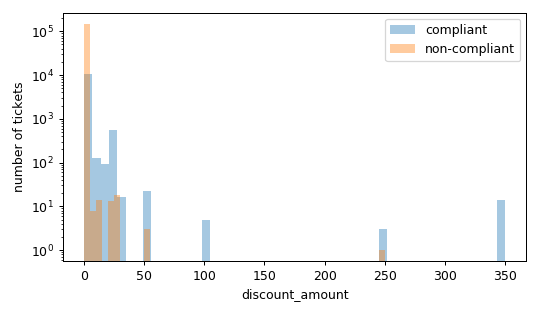

In [5]:
fig1= plt.figure(figsize=(6,3.5))
for i,j in [(1,"compliant"),(0,"non-compliant")]:
        data = df1[df1["compliance"]==i]
        sns.distplot(data["discount_amount"],label=j,hist=True,norm_hist=False,kde=False)
plt.gca().set_yscale("log")
plt.gca().set_ylabel("number of tickets")
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


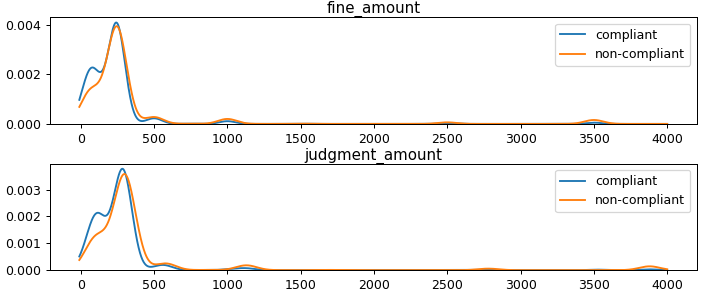

In [6]:
fig2, _ = plt.subplots(2,1,figsize=(8,1.7*2)) 
plt.tight_layout()
for i,var in enumerate(["fine_amount","judgment_amount"]):
    axi=plt.subplot(2,1,i+1)
    for i,j in [(1,"compliant"),(0,"non-compliant")]:
        data = df1[df1["compliance"]==i]
        sns.kdeplot(data[var],label=j,gridsize=2500,clip=(-10,4000))
        axi.set_title(var,pad=.15)

<IPython.core.display.Javascript object>


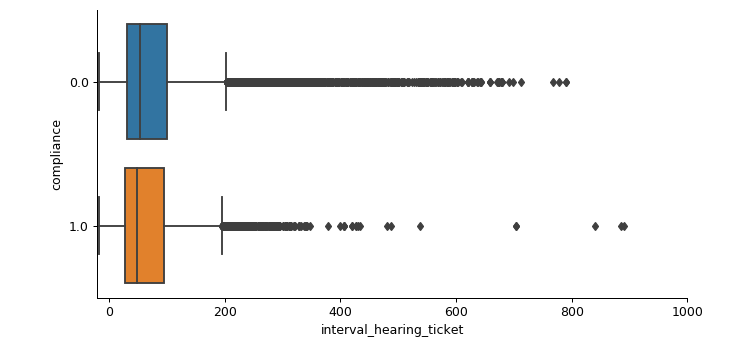

In [9]:
# time interval between hearing and ticket issued date
df1["ticket_issued_date"] = pd.to_datetime(df1["ticket_issued_date"]) #df1["ticket_issued_date"].astype("datetime64[D]")
df1["hearing_date"]=pd.to_datetime(df1["hearing_date"])

df1["interval_hearing_ticket"] = df1.hearing_date - df1.ticket_issued_date
df1["interval_hearing_ticket"] = df1["interval_hearing_ticket"].apply(lambda x: x.days)
sns.catplot(x='interval_hearing_ticket',y='compliance', kind="box",data=df1,orient="horizontal")
plt.gca().set_xlim([-20,1000])
plt.tight_layout()

In [10]:
#makes no sense when hearing date before ticket_issued_date, probably its an error on the data
print("tickets where hearing date is before ticket_issued date: {}".format( len(df1[ df1.interval_hearing_ticket<0])))
df1.drop(df1[ df1.interval_hearing_ticket<0].index, inplace=True)

tickets where hearing date is before ticket_issued date: 80


<IPython.core.display.Javascript object>


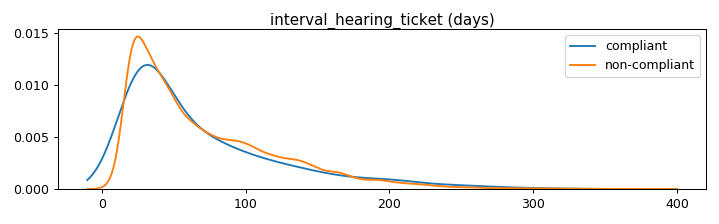

In [11]:
fig4 = plt.figure(figsize=(8,2.5))
for i,j in [(1,"compliant"),(0,"non-compliant")]:
    data = df1[df1["compliance"]==i]
    sns.kdeplot(data["interval_hearing_ticket"],label=j,gridsize=1500,clip=(-10,400))
    plt.gca().set_title("interval_hearing_ticket (days)",pad=.15)
fig4.tight_layout()

In [ ]:
# encode non-numerical variables
encoding_lists =[]
non_numerical_vars = ["disposition","violation_street_name"]
for i in non_numerical_vars:
    encoding_list = list(enumerate( df1[i].unique() ))
    encoding_lists.append(  encoding_list  )
    df1[i] = df1[i].apply(  lambda x: [y[0] for y in encoding_list if y[1]==x][0]  )

In [12]:
print(df1.dtypes)
df1.describe()

violation_street_name              object
ticket_issued_date         datetime64[ns]
hearing_date               datetime64[ns]
disposition                        object
fine_amount                       float64
discount_amount                   float64
judgment_amount                   float64
compliance                        float64
interval_hearing_ticket             int64
dtype: object


,fine_amount,discount_amount,judgment_amount,compliance,interval_hearing_ticket
count,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000
mean,356.856755,0.167384,420.486152,0.071585,72.749387
std,675.672888,3.960415,742.605232,0.257800,62.451159
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,250.000000,0.000000,31.000000
50%,250.000000,0.000000,305.000000,0.000000,54.000000
75%,250.000000,0.000000,305.000000,0.000000,100.000000
max,10000.000000,350.000000,11030.000000,1.000000,7933.000000


In [ ]:
#vars_to_plot = ["fine_amount","discount_amount","judgment_amount","interval_hearing_ticket","compliance_detail","disposition"]
#vars_for_model = ["fine_amount","discount_amount","judgment_amount","interval_hearing_ticket","violation_street_name","disposition"]
#vars_for_model = ["fine_amount","discount_amount","judgment_amount","violation_street_name","disposition"]
#vars_for_model = ["fine_amount","discount_amount","judgment_amount","violation_street_name","disposition"]
vars_for_model = ["fine_amount","discount_amount","judgment_amount","disposition"]

In [ ]:
sns.set(style="ticks")
sns.pairplot(df1,vars=vars_for_model,diag_kind="hist",hue="compliance")

## street names and lat-log indexed  by ticket_id

In [13]:
dfa = pd.read_csv("addresses.csv")
dfa.dropna(inplace=True)
print(len(dfa))
street_parser = lambda x:  x.split(",")[0].split(" ")[1].strip()
address_parser = lambda x: x.split(",")[0].strip()
dfa["street"] = dfa["address"].apply(street_parser)
dfa["address"] = dfa["address"].apply(address_parser)
dfa.head(3)
#ctiy var not usea, unique value is Detroit
#city_parser   = lambda x : x.split(",")[1].strip().split(" ")[0]
#dfa["city"]   = dfa["address"].apply( city_parser )
#len(dfa.street.unique())

FileNotFoundError: [Errno 2] File b'addresses.csv' does not exist: b'addresses.csv'

In [ ]:
dflalo = pd.read_csv("latlons.csv")
dflalo.dropna(inplace=True)
dflalo["street"]=dflalo["address"].apply(street_parser)
dflalo["address"]=dflalo["address"].apply(address_parser)
print(len(dflalo) )
dflalo.head(3)

In [ ]:
print(  "Number of different street names in adresses csv: {}".format(len(dfa.street.unique())) )
print(  "Number of different street names in latlon  csv: {}".format(len(dflalo.street.unique())) )
print(  "Number of different street names in train data set: {}".format(len(df1.violation_street_name.unique())) )

In [ ]:
df_spatial = dfa.set_index("address").join(dflalo.set_index("address"),how="left",lsuffix='_caller', rsuffix='_other')
df_spatial.dropna(inplace=True)
len(df_spatial)

## Model Creation

In [ ]:
#model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#metric chosen AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score

### Simplest 0:  Logistic classifier  1-cv fold 

In [ ]:
#vars_for_model.append("compliance")
print(vars_for_model)
#df1.columns

In [ ]:
X = df1[vars_for_model].values #as_matrix();
y = df1["compliance"].values    #.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

print("y_1/y0 full data: {}".format(sum(y==1)/sum(y==0)))
print("y_1/y0 train    : {}".format(sum(y_train==1)/sum(y_train==0)))
print("y_1/y0 test     : {}".format(sum(y_test==1)/sum(y_test==0)))
#Conclusion: scikit learn handels and homogeneous distribution of the data

scaler=MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

logic_reg = LogisticRegression()

In [ ]:
grid_values = {'C': [0.01, 0.1, 1, 10, 100, 150, 200], 'penalty':['l1','l2']}
grid_clf = GridSearchCV(logic_reg,param_grid=grid_values,scoring='roc_auc',n_jobs=-1)

# alternative metric to optimize over grid parameters: AUC
grid_clf.fit(X_train_scaled, y_train)
y_decision_fn_scores_auc = grid_clf.decision_function(X_test_scaled) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best score (AUC): ', grid_clf.best_score_)

In [ ]:
y_pred= grid_clf.predict(X_test_scaled)
print(grid_clf.best_params_)
print(classification_report(y_test,y_pred))

In [ ]:
for i in non_numerical_vars:
    print("Trainset unique elements {}: {}".format(i,len(list(df1[i].unique()))))
    print("Testset  unique elements {}: {}".format(i,len(list(df1_cv[i].unique()))))
    

In [ ]:
print("##### disposition values for df1_cv")
for i in encoding_lists_cv[0]: print(i)
print("#####  disposition values for df1")
for i in encoding_lists[0]: print(i)